# Libraries

In [27]:
!pip install svgwrite


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [176]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

import sys, os
py_file_location = "/content/gdrive/My Drive/AML6/"
sys.path.append(os.path.abspath(py_file_location))

Mounted at /content/gdrive/


In [28]:
import svgwrite
from IPython.display import display, SVG
import numpy as np
import random
import seaborn as sns

# Drawing function

In [29]:
palette = sns.color_palette('viridis', 101)
palette = [(int(p[0]*255),int(p[1]*255),int(p[2]*255)) for p in palette]

def draw(im, show=True, unit=10, depart=(0,0), goal=(29,9), paths=None, title='default.svg'):

    im = im*1.
    padding = 1.5 * unit
    size_x = (2*padding) + im.shape[0]*unit
    size_y = (2*padding) + im.shape[1]*unit
    dwg = svgwrite.Drawing(py_file_location+'_svg/'+title, size=(size_x, size_y))

    for i in range(im.shape[0]):
        for ii in range(im.shape[1]):

            g = int(im[i,ii])
            rgb = palette[g]
            color = svgwrite.rgb(*rgb)
            x, y = padding + (i*unit), padding + (ii*unit)
            tile = dwg.rect(insert=(x,y), size=(unit,unit)).fill(color)
            dwg.add(tile)

    agent_color = svgwrite.rgb(255, 0, 0)
    stroke = 2.
    t_unit = unit - stroke
    t_size = 3.

    if paths is not None:
        for path in paths:
          points = [(padding + (coo[0] * unit) + (0.5 * unit), padding + (coo[1] * unit) + (0.5 * unit)) for coo in path]
          #path = dwg.polyline(points=points, fill="none").stroke(color="white", width=stroke*3)
          #dwg.add(path)
          path = dwg.polyline(points=points, fill="none").stroke(color=agent_color, width=stroke)
          dwg.add(path)

    # departure and goal
    dpt_x, dpt_y = (unit * 0.5) + padding + depart[0] * unit, (unit * 0.5) + padding + depart[1] * unit
    dpt = dwg.circle(center=(dpt_x,dpt_y), r=t_unit*(t_size*0.8)).fill(agent_color).stroke(color="white", width=stroke)
    dwg.add(dpt)

    arr_x, arr_y = (unit * 0.5) + padding + goal[0] * unit, (unit * 0.5) + padding + goal[1] * unit
    pt1 = (arr_x + np.sin(np.deg2rad(60)) * t_unit * t_size, arr_y + np.cos(np.deg2rad(60)) * t_unit * t_size)
    pt2 = (arr_x, arr_y - (t_unit * t_size))
    pt3 = (arr_x - np.sin(np.deg2rad(60)) * t_unit * t_size, arr_y + np.cos(np.deg2rad(60)) * t_unit * t_size)
    points = [pt1, pt2, pt3]
    arrival = dwg.polygon(points=points).stroke(color="white", width=stroke).fill(agent_color)
    dwg.add(arrival)

    if show: display(SVG(dwg.tostring()))
    return dwg


# Data

In [30]:
py_file_location = ''
import numpy as np
import json
with open(py_file_location+'_json/xyz.json', 'r') as f:
    XYZ = np.array(json.load(f))

# Model

In [31]:
M, N = XYZ.shape
print (M, N)
XYZ[:5,:5]

140 100


array([[1.75281993, 2.20349821, 0.39252358, 0.15336861, 0.71133869],
       [0.58090414, 0.47255528, 0.04671693, 0.43491874, 0.22772565],
       [0.08492156, 0.        , 0.22637886, 1.78536252, 2.23335983],
       [1.44392988, 2.08848844, 1.56313176, 0.36974565, 2.09144632],
       [2.92843099, 3.0257302 , 1.89053942, 0.32816689, 1.72886461]])

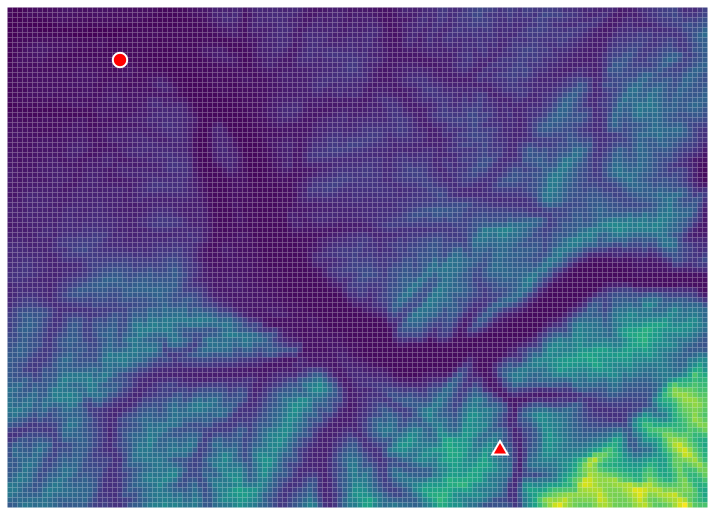

In [32]:
start_pos = (22, 10) # Bern
end_pos =   (98, 88) # Mürren
dwg = draw (XYZ, depart=start_pos, goal=end_pos, unit=5, title="map.svg")
dwg.save()

In [54]:
# Define the environment
grid_size = (M, N)
rewards = XYZ
start_pos = (22, 10) # Bern
end_pos =   (98, 88) # Mürren

# Define actions
actions = ['ur', 'ul', 'dr', 'dl']
action_to_index = {action: i for i, action in enumerate(actions)}

def get_next_state(state, action):
    x, y = state
    if action == 'ur': x -= 1; y += 1
    elif action == 'ul': x -= 1; y -= 1
    elif action == 'dr': x += 1; y += 1
    elif action == 'dl': x += 1; y -= 1
    return x, y

def training(generalize=False, capture_progression=False, printEvery=5000, num_episodes=100000, max_steps=250):

    # Hyperparameters
    alpha = 0.005           # Learning rate
    gamma = 0.9             # Discount factor
    epsilon = 0.99          # Exploration rate

    Q_table = np.zeros((M, N, len(actions)))

    scores = []
    previous_reached = 0
    reached = 0
    last_z = 0

    for episode in range(num_episodes):
        
        if generalize:
            state = (random.choice(range(int(M/2.)))*2, random.choice(range(int(N/2.)))*2)
        else:
            state = start_pos
            
        path = [state]
        total_reward = 0

        for step in range(max_steps):
            x, y = state

            # Choose action: epsilon-greedy strategy
            if random.uniform(0, 1) < epsilon:
                action = random.choice(actions)  # Explore
            else:
                action = actions[np.argmin(Q_table[x, y])]  # Exploit

            # Get next state
            next_state = get_next_state(state, action)
            path.append(next_state)
            nx, ny = next_state

            # Check if next state is out of bounds
            if nx < 0 or nx >= grid_size[0] or ny < 0 or ny >= grid_size[1]:
                reward = 10000
                total_reward += reward
                Q_table[x, y, action_to_index[action]] += alpha * (reward - Q_table[x, y, action_to_index[action]])
                break

            else:
                distance = ((nx-end_pos[0])**2 + (ny-end_pos[1])**2) ** 0.5
                reward = distance + (rewards[nx, ny] * distance * 1e-1)
                total_reward += reward

                Q_table[x, y, action_to_index[action]] += alpha * (
                    reward + gamma * np.min(Q_table[nx, ny]) - Q_table[x, y, action_to_index[action]]
                )

                state = next_state

                if state == end_pos:
                    reached += 1
                    break

        scores.append(total_reward)

        if capture_progression:
            if episode%100==0:
                dwg = draw(XYZ, depart=start_pos, goal=end_pos, unit=5, 
                           paths=[path], show=False, title=f"{int(episode/100.):05d}.svg")
                dwg.save()
                
        if episode%printEvery==0 or episode==num_episodes-1:
            print (f"Episode {episode: 7d}, score {total_reward: 10.1f}, reached {reached - previous_reached: 5d}")
            previous_reached = reached

        # Optionally, decay epsilon to reduce exploration over time
        epsilon = max(0.1, epsilon * 0.999)

    print ("total reached", reached)
    
    return Q_table, scores

In [46]:
Q_table_1, scores_1 = training(max_steps=250,
                               generalize=False, 
                               capture_progression=True, 
                               printEvery=5000, 
                               num_episodes=125000)

with open(py_file_location+'_json/Q_table_1.json', 'w') as f:
    json.dump(Q_table_1.tolist(), f)
    print ('Q_table saved.')

Episode       0, score    36092.9, reached     0
Episode    5000, score    36931.0, reached     0
Episode   10000, score    30851.4, reached     0
Episode   15000, score    43235.0, reached     0
Episode   20000, score    44374.3, reached     0
Episode   25000, score    27482.6, reached     0
Episode   30000, score    38741.6, reached     0
Episode   35000, score    40936.5, reached     0
Episode   40000, score    14204.1, reached     0
Episode   45000, score    34359.7, reached     0
Episode   50000, score    24594.7, reached     0
Episode   55000, score    32401.5, reached     0
Episode   60000, score    34807.6, reached     4
Episode   65000, score    21115.8, reached    30
Episode   70000, score    31281.0, reached   151
Episode   75000, score    14801.7, reached   496
Episode   80000, score    19220.4, reached  1200
Episode   85000, score    10989.4, reached  2029
Episode   90000, score    31595.5, reached  2879
Episode   95000, score    10439.5, reached  3621
Episode  100000, sco

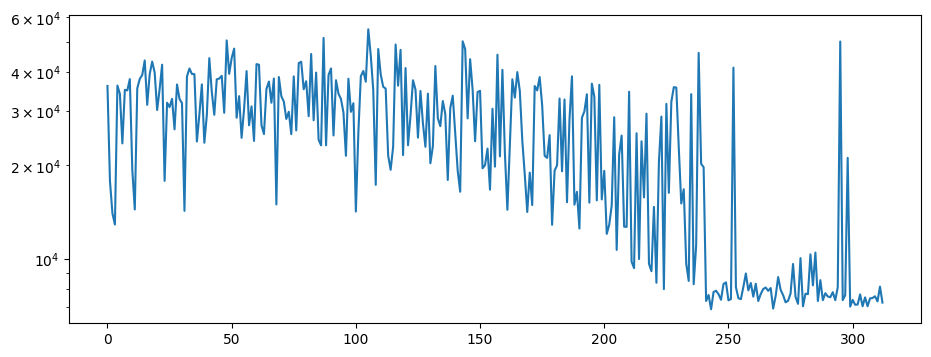

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(11,4))
plt.yscale('log')
_ = plt.plot(scores_1[::400])

In [55]:
Q_table_general, scores_general = training(max_steps=300,
                                           generalize=True, 
                                           capture_progression=False, 
                                           printEvery=50000, 
                                           num_episodes=2000000)

with open(py_file_location+'_json/Q_table_general.json', 'w') as f:
    json.dump(Q_table_general.tolist(), f)
    print ('Q_table saved.')

Episode       0, score    51563.6, reached     0
Episode   50000, score     2938.3, reached  8495
Episode  100000, score      969.1, reached  18628
Episode  150000, score    51490.1, reached  27504
Episode  200000, score    10564.0, reached  33236
Episode  250000, score    11261.0, reached  37342
Episode  300000, score    15531.5, reached  39896
Episode  350000, score     6213.2, reached  41953
Episode  400000, score    32760.2, reached  43462
Episode  450000, score    18058.5, reached  44583
Episode  500000, score     7340.3, reached  44629
Episode  550000, score     5432.2, reached  42218
Episode  600000, score     3602.3, reached  41384
Episode  650000, score      919.2, reached  40052
Episode  700000, score       20.6, reached  39571
Episode  750000, score     2026.7, reached  39117
Episode  800000, score     2238.9, reached  38863
Episode  850000, score      737.5, reached  38532
Episode  900000, score     2785.5, reached  38506
Episode  950000, score     3196.3, reached  38395
Ep

In [56]:
with open(py_file_location+'_json/Q_table_general.json', 'w') as f:
    json.dump(Q_table_general.tolist(), f)
    print ('Q_table saved.')

Q_table saved.


In [23]:
# Function to extract the optimal policy from the Q-table
def get_optimal_policy(Q_table):
    grid_size = Q_table.shape
    policy = np.full(grid_size[:2], '', dtype=object)

    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            # Choose the action with the minimum Q-value for each state
            best_action_index = np.argmin(Q_table[x, y])
            policy[x, y] = actions[best_action_index]

    return policy

# Function to simulate a run using the optimal policy
def simulate_policy(policy, start_state=start_pos, end_state=end_pos):

    state = start_state
    path = [state]
    total_reward = 0
    steps = 0
    last_z = 0

    while state != end_state and steps < max_steps:  # Stop if goal is reached or max steps exceeded
        x, y = state
        action = policy[x, y]
        next_state = get_next_state(state, action)

        # Check for out-of-bounds
        nx, ny = next_state
        if nx < 0 or nx >= grid_size[0] or ny < 0 or ny >= grid_size[1]:
            total_reward += 10000  # Out-of-bounds penalty
            break

        # Add reward for the next state
        z = rewards[nx, ny]
        delta = abs(z - last_z)
        reward = delta
        total_reward += reward
        last_z = z

        state = next_state
        path.append(state)
        steps += 1

    return path, total_reward

In [57]:
# Derive the optimal policy
optimal_policy = get_optimal_policy(Q_table_general)

# Visualize the optimal policy
print("Optimal Policy :")
print (optimal_policy[0])
print ('...')

Optimal Policy :
['dr' 'ur' 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dr' 'ur'
 'dr' 'ur' 'dr' 'ur' 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dr' 'ur'
 'dl' 'ur' 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur'
 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dr' 'ur' 'dl' 'ur' 'dr' 'ur'
 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dr' 'ur' 'dl' 'ur' 'dr' 'ur' 'dr' 'ur'
 'dl' 'ur' 'dl' 'ur' 'dr' 'ur' 'dr' 'ur' 'dl' 'ur' 'dr' 'ur' 'dr' 'ur'
 'dr' 'ur' 'dl' 'ur' 'dl' 'ur' 'dl' 'ur' 'dr' 'ur' 'dl' 'ur' 'dr' 'ur'
 'dr' 'ur']
...


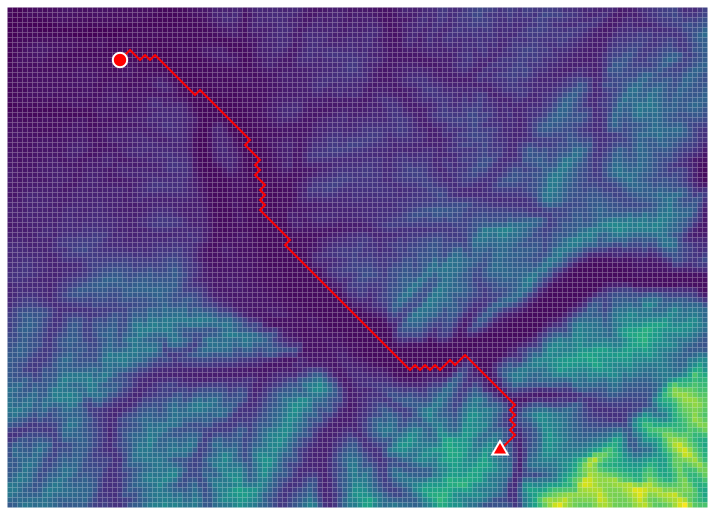

In [26]:
# Bern to Mürren

path, _ = simulate_policy(optimal_policy, start_state=start_pos, end_state=end_pos)
dwg = draw (XYZ, depart=start_pos, goal=end_pos, unit=5, paths=[path], title="bern_muerren.svg")
dwg.save()

In [60]:
# (almost) all roads lead to Mürren

print (len(XYZ.ravel()))

start_pos_list = []
for i in range(len(XYZ.ravel())):
  x = i%140
  y = i//140
  if x%2!=0 or y%2!=0: continue
  start_pos_list.append((x,y))

paths = []
for pos in start_pos_list:
  path, _ = simulate_policy(optimal_policy, start_state=pos, end_state=end_pos)
  paths.append(path)

dwg = draw (XYZ, depart=start_pos, goal=end_pos, unit=5, paths=paths, title="all_roads.svg")
dwg.save()

14000


In [ ]:
# Show that the best policy path is not necessarily the local minimum
# the model has a larger knowledge of the terrain

# Javascript array

In [61]:
print (paths[1500])

[(60, 42), (59, 43), (60, 44), (59, 45), (58, 46), (57, 47), (56, 48), (57, 49), (58, 50), (59, 51), (60, 52), (61, 53), (62, 54), (63, 55), (64, 56), (65, 57), (66, 58), (67, 59), (68, 60), (69, 61), (70, 62), (71, 63), (72, 64), (73, 65), (74, 66), (75, 67), (76, 68), (77, 69), (78, 70), (79, 71), (80, 72), (81, 73), (82, 72), (83, 71), (84, 72), (85, 71), (86, 72), (87, 71), (88, 70), (89, 71), (90, 70), (91, 69), (92, 70), (93, 71), (94, 72), (95, 73), (96, 74), (97, 75), (98, 76), (99, 77), (100, 78), (101, 79), (100, 80), (101, 81), (100, 82), (101, 83), (100, 84), (101, 85), (100, 86), (99, 87), (98, 88)]


In [62]:
spaths = []

scale = 5
for path in paths:
    s = ""
    for coords in path:
        a, b = coords
        s += str(a*scale)+','+str(b*scale)+' '
    spaths.append(s)

print (len(spaths))

3500


In [63]:
print (spaths)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

